In [ ]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings('ignore')

# Set plotting style for better visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully for distributed systems performance analysis")

Libraries imported successfully for distributed systems performance analysis


In [ ]:
def load_benchmark_data(base_path, strategy_type):
    """
    Load benchmark data for erasure coding or replication strategy
    
    Args:
        base_path: Path to benchmark results
        strategy_type: 'erasure' or 'replication'
    
    Returns:
        DataFrame with performance metrics
    """
    data_path = os.path.join(base_path, f"results_store/_final/{strategy_type}/write_avgnet")
    
    if not os.path.exists(data_path):
        print(f"Warning: Path {data_path} does not exist")
        return pd.DataFrame()
    
    results = []
    
    # Parse file naming pattern: _write_{payload}b_1vu_{bandwidth}mbit.json
    for filename in os.listdir(data_path):
        if filename.startswith('_write_') and filename.endswith('.json'):
            try:
                # Extract parameters from filename
                parts = filename.replace('_write_', '').replace('.json', '').split('_')
                payload_bytes = int(parts[0].replace('b', ''))
                bandwidth_mbit = int(parts[2].replace('mbit', ''))
                
                # Load JSON data
                with open(os.path.join(data_path, filename), 'r') as f:
                    data = json.load(f)
                
                # Extract performance metrics
                summary = data.get('summary', {})
                perf = summary.get('success_performance', {})
                reqs = summary.get('reqs', {})
                
                # Load CPU data
                cpu_file = f"cpu_avg_{payload_bytes}b_1vu_{bandwidth_mbit}mbit.txt"
                cpu_path = os.path.join(data_path, cpu_file)
                cpu_usage = 0
                if os.path.exists(cpu_path):
                    with open(cpu_path, 'r') as f:
                        lines = f.readlines()
                        for line in lines:
                            if 'Average CPU usage' in line:
                                cpu_usage = float(line.split(':')[1].strip())
                                break
                
                results.append({
                    'strategy': strategy_type,
                    'payload_bytes': payload_bytes,
                    'payload_kb': payload_bytes / 1024,
                    'bandwidth_mbit': bandwidth_mbit,
                    'avg_latency_ms': perf.get('avg', 0),
                    'min_latency_ms': perf.get('min', 0),
                    'max_latency_ms': perf.get('max', 0),
                    'p90_latency_ms': perf.get('p(90)', 0),
                    'p95_latency_ms': perf.get('p(95)', 0),
                    'median_latency_ms': perf.get('med', 0),
                    'request_rate': reqs.get('rate', 0),
                    'total_requests': reqs.get('count', 0),
                    'cpu_usage_percent': cpu_usage,
                    'throughput_ops_sec': reqs.get('rate', 0)
                })
                
            except (ValueError, KeyError, json.JSONDecodeError) as e:
                print(f"Error processing {filename}: {e}")
                continue
    
    return pd.DataFrame(results)

# Load data for both strategies
base_path = "/home/ostree/ta/paxos-rust/benchmark"
erasure_data = load_benchmark_data(base_path, "erasure")
replication_data = load_benchmark_data(base_path, "replication")

# Combine datasets
combined_data = pd.concat([erasure_data, replication_data], ignore_index=True)

In [ ]:
# Data exploration and validation
# Overview
print(f"Erasure coding samples: {len(erasure_data)}")
print(f"Replication samples: {len(replication_data)}")
print(f"Total samples: {len(combined_data)}")

# Unique data
print("Unique payload sizes:", sorted(combined_data['payload_kb'].unique()))
print("Unique bandwidth values:", sorted(combined_data['bandwidth_mbit'].unique()))

# Metrics summary
print(combined_data.groupby('strategy')[['avg_latency_ms', 'throughput_ops_sec']].describe())

# Check for missing data
missing_data = combined_data.isnull().sum()
print("Missing values per column:")
print(missing_data[missing_data > 0])

# Basic statistics comparison
strategy_comparison = combined_data.groupby('strategy').agg({
    'avg_latency_ms': ['mean', 'std', 'min', 'max'],
    'throughput_ops_sec': ['mean', 'std', 'min', 'max'],
    'cpu_usage_percent': ['mean', 'std', 'min', 'max']
}).round(4)
print(strategy_comparison)

Erasure coding samples: 25
Replication samples: 25
Total samples: 50
Unique payload sizes: [np.float64(195.3125), np.float64(390.625), np.float64(585.9375), np.float64(781.25), np.float64(976.5625)]
Unique bandwidth values: [np.int64(10), np.int64(25), np.int64(40), np.int64(55), np.int64(70)]
            avg_latency_ms                                                    \
                     count         mean          std         min         25%   
strategy                                                                       
erasure               25.0   903.106263   746.303910  241.722793  457.927517   
replication           25.0  1363.821353  1644.737184  151.345583  445.896458   

                                                  throughput_ops_sec  \
                    50%          75%          max              count   
strategy                                                               
erasure      669.386850   975.910794  3282.157200               25.0   
replication  790

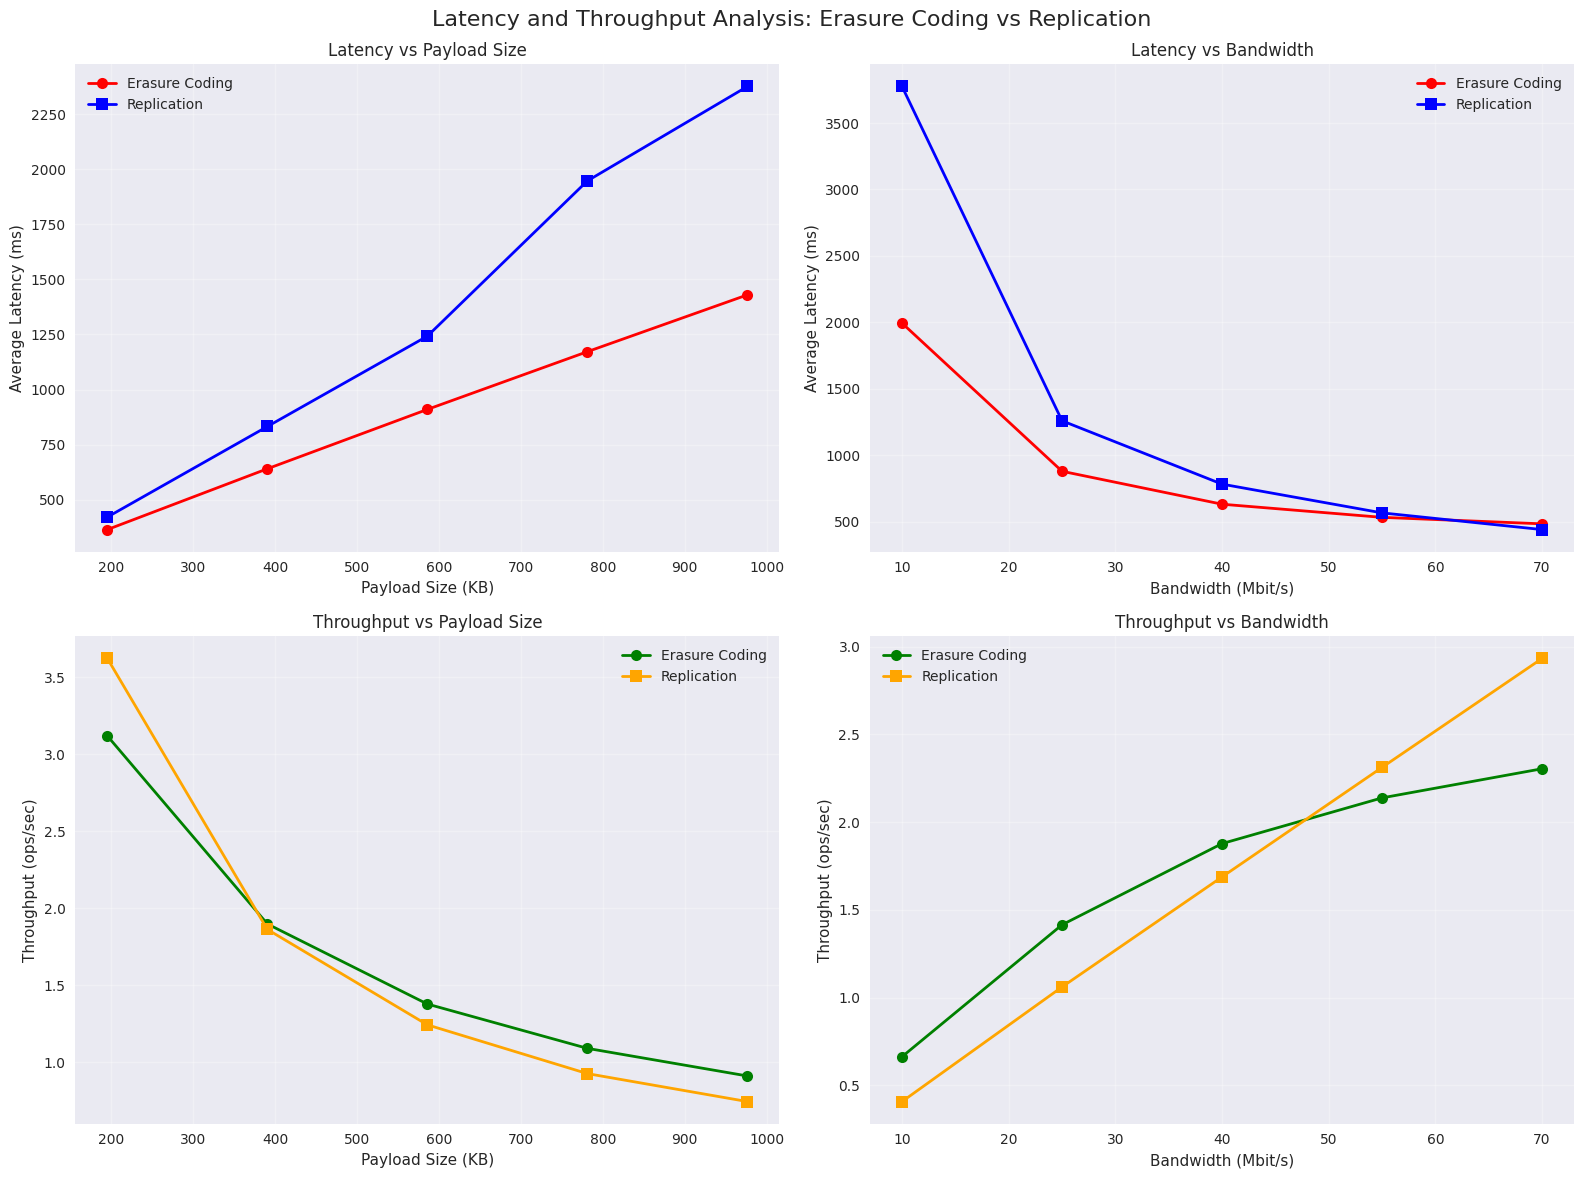

In [ ]:
# Calculate performance ratios between erasure coding and replication
def calculate_performance_ratios(erasure_df, replication_df):
    """
    Calculate performance ratios between erasure coding and replication
    for matching bandwidth and payload configurations
    """
    ratios = []
    
    for _, ec_row in erasure_df.iterrows():
        # Find matching replication configuration
        matching_rep = replication_df[
            (replication_df['payload_kb'] == ec_row['payload_kb']) &
            (replication_df['bandwidth_mbit'] == ec_row['bandwidth_mbit'])
        ]
        
        if not matching_rep.empty:
            rep_row = matching_rep.iloc[0]
            
            # Calculate performance ratios for latency and throughput only
            latency_ratio = ec_row['avg_latency_ms'] / rep_row['avg_latency_ms']
            throughput_ratio = ec_row['throughput_ops_sec'] / rep_row['throughput_ops_sec']
            cpu_ratio = ec_row['cpu_usage_percent'] / rep_row['cpu_usage_percent'] if rep_row['cpu_usage_percent'] > 0 else 1
            
            ratios.append({
                'payload_kb': ec_row['payload_kb'],
                'bandwidth_mbit': ec_row['bandwidth_mbit'],
                'latency_ratio_ec_to_rep': latency_ratio,
                'throughput_ratio_ec_to_rep': throughput_ratio,
                'cpu_ratio_ec_to_rep': cpu_ratio,
                'ec_latency': ec_row['avg_latency_ms'],
                'rep_latency': rep_row['avg_latency_ms'],
                'ec_throughput': ec_row['throughput_ops_sec'],
                'rep_throughput': rep_row['throughput_ops_sec']
            })
    
    return pd.DataFrame(ratios)

# Calculate ratios
ratio_data = calculate_performance_ratios(erasure_data, replication_data)

# Create visualization focused on latency and throughput
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Latency and Throughput Analysis: Erasure Coding vs Replication', fontsize=16)

# 1. Latency comparison by payload size
ax1 = axes[0, 0]
payload_sizes = sorted(ratio_data['payload_kb'].unique())
ec_latencies = [ratio_data[ratio_data['payload_kb'] == p]['ec_latency'].mean() for p in payload_sizes]
rep_latencies = [ratio_data[ratio_data['payload_kb'] == p]['rep_latency'].mean() for p in payload_sizes]

ax1.plot(payload_sizes, ec_latencies, 'o-', label='Erasure Coding', linewidth=2, markersize=8, color='red')
ax1.plot(payload_sizes, rep_latencies, 's-', label='Replication', linewidth=2, markersize=8, color='blue')
ax1.set_xlabel('Payload Size (KB)')
ax1.set_ylabel('Average Latency (ms)')
ax1.set_title('Latency vs Payload Size')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Latency comparison by bandwidth
ax2 = axes[0, 1]
bandwidths = sorted(ratio_data['bandwidth_mbit'].unique())
ec_latency_bw = [ratio_data[ratio_data['bandwidth_mbit'] == b]['ec_latency'].mean() for b in bandwidths]
rep_latency_bw = [ratio_data[ratio_data['bandwidth_mbit'] == b]['rep_latency'].mean() for b in bandwidths]

ax2.plot(bandwidths, ec_latency_bw, 'o-', label='Erasure Coding', linewidth=2, markersize=8, color='red')
ax2.plot(bandwidths, rep_latency_bw, 's-', label='Replication', linewidth=2, markersize=8, color='blue')
ax2.set_xlabel('Bandwidth (Mbit/s)')
ax2.set_ylabel('Average Latency (ms)')
ax2.set_title('Latency vs Bandwidth')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Throughput comparison by payload size
ax3 = axes[1, 0]
ec_throughputs = [ratio_data[ratio_data['payload_kb'] == p]['ec_throughput'].mean() for p in payload_sizes]
rep_throughputs = [ratio_data[ratio_data['payload_kb'] == p]['rep_throughput'].mean() for p in payload_sizes]

ax3.plot(payload_sizes, ec_throughputs, 'o-', label='Erasure Coding', linewidth=2, markersize=8, color='green')
ax3.plot(payload_sizes, rep_throughputs, 's-', label='Replication', linewidth=2, markersize=8, color='orange')
ax3.set_xlabel('Payload Size (KB)')
ax3.set_ylabel('Throughput (ops/sec)')
ax3.set_title('Throughput vs Payload Size')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Throughput comparison by bandwidth
ax4 = axes[1, 1]
ec_throughput_bw = [ratio_data[ratio_data['bandwidth_mbit'] == b]['ec_throughput'].mean() for b in bandwidths]
rep_throughput_bw = [ratio_data[ratio_data['bandwidth_mbit'] == b]['rep_throughput'].mean() for b in bandwidths]

ax4.plot(bandwidths, ec_throughput_bw, 'o-', label='Erasure Coding', linewidth=2, markersize=8, color='green')
ax4.plot(bandwidths, rep_throughput_bw, 's-', label='Replication', linewidth=2, markersize=8, color='orange')
ax4.set_xlabel('Bandwidth (Mbit/s)')
ax4.set_ylabel('Throughput (ops/sec)')
ax4.set_title('Throughput vs Bandwidth')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

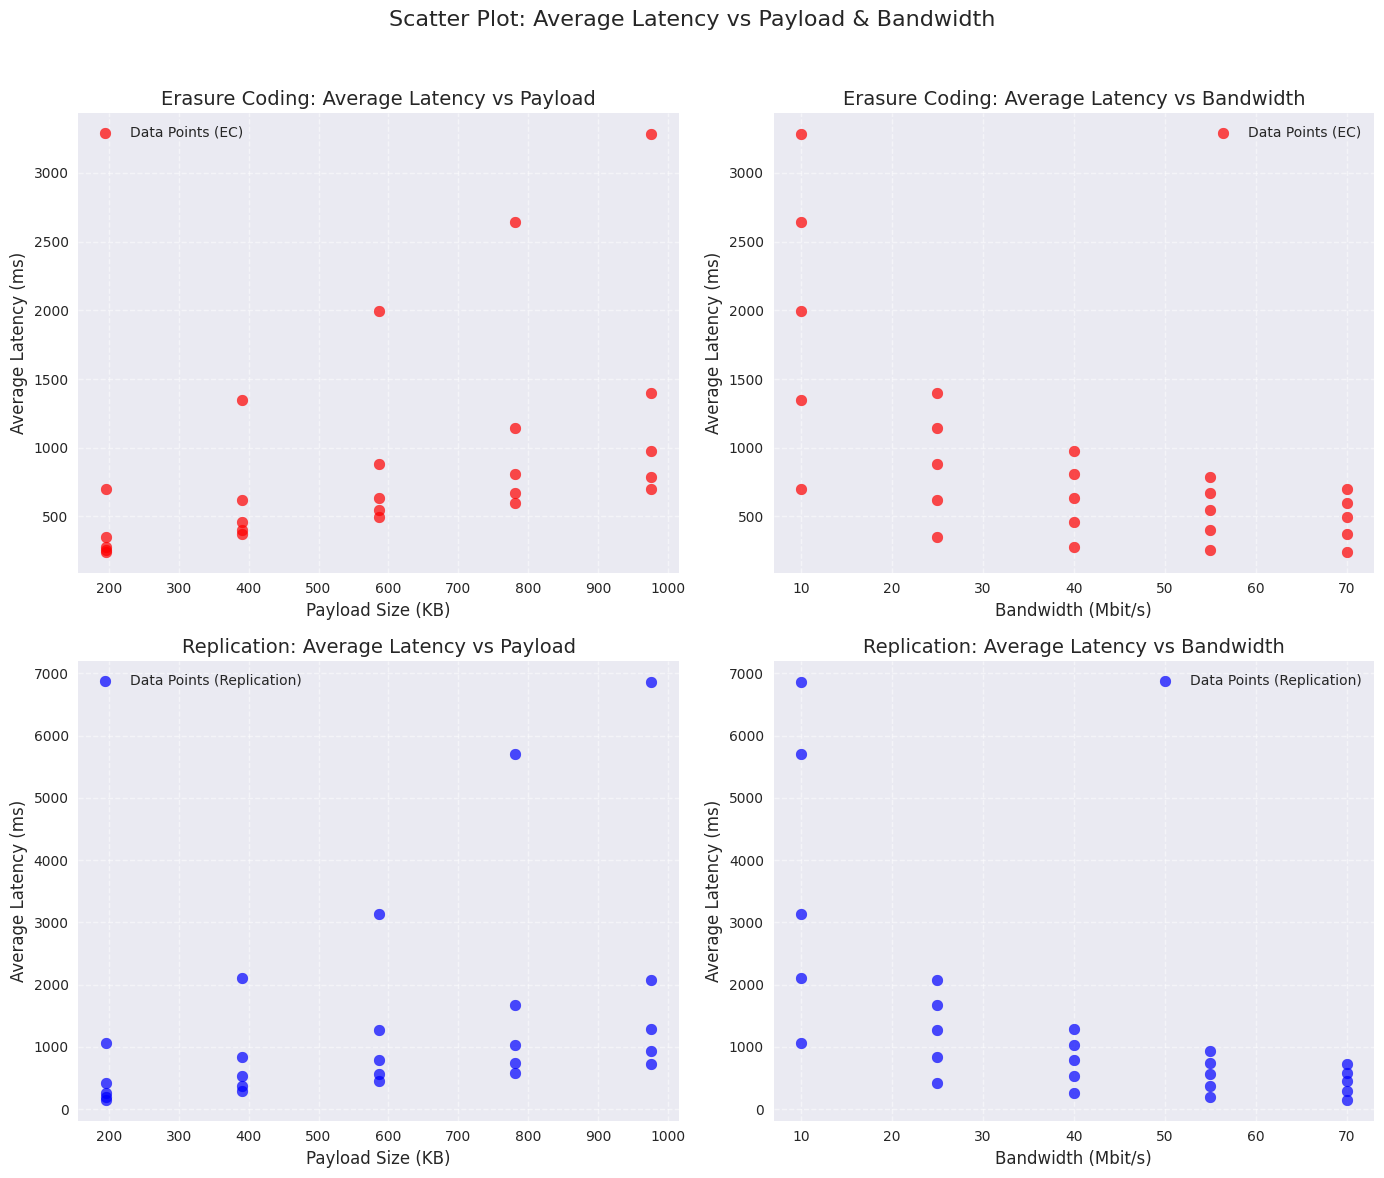

In [ ]:
# Ekstrak data latensi untuk Erasure Coding dan Replication
ec_data = erasure_data.copy()
rep_data = replication_data.copy()

# --- Visualisasi Scatter Plot ---
# Membuat visualisasi
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Scatter Plot: Average Latency vs Payload & Bandwidth', fontsize=16)

# 1. EC: Average Latency vs Payload
ax1 = axes[0, 0]
ax1.scatter(ec_data['payload_kb'], ec_data['avg_latency_ms'], color='red', alpha=0.7, s=60, label='Data Points (EC)')
ax1.set_xlabel('Payload Size (KB)', fontsize=12)
ax1.set_ylabel('Average Latency (ms)', fontsize=12)
ax1.set_title('Erasure Coding: Average Latency vs Payload', fontsize=14)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.5)

# 2. EC: Average Latency vs Bandwidth
ax2 = axes[0, 1]
ax2.scatter(ec_data['bandwidth_mbit'], ec_data['avg_latency_ms'], color='red', alpha=0.7, s=60, label='Data Points (EC)')
ax2.set_xlabel('Bandwidth (Mbit/s)', fontsize=12)
ax2.set_ylabel('Average Latency (ms)', fontsize=12)
ax2.set_title('Erasure Coding: Average Latency vs Bandwidth', fontsize=14)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.5)

# 3. Replication: Average Latency vs Payload
ax3 = axes[1, 0]
ax3.scatter(rep_data['payload_kb'], rep_data['avg_latency_ms'], color='blue', alpha=0.7, s=60, label='Data Points (Replication)')
ax3.set_xlabel('Payload Size (KB)', fontsize=12)
ax3.set_ylabel('Average Latency (ms)', fontsize=12)
ax3.set_title('Replication: Average Latency vs Payload', fontsize=14)
ax3.legend()
ax3.grid(True, linestyle='--', alpha=0.5)

# 4. Replication: Average Latency vs Bandwidth
ax4 = axes[1, 1]
ax4.scatter(rep_data['bandwidth_mbit'], rep_data['avg_latency_ms'], color='blue', alpha=0.7, s=60, label='Data Points (Replication)')
ax4.set_xlabel('Bandwidth (Mbit/s)', fontsize=12)
ax4.set_ylabel('Average Latency (ms)', fontsize=12)
ax4.set_title('Replication: Average Latency vs Bandwidth', fontsize=14)
ax4.legend()
ax4.grid(True, linestyle='--', alpha=0.5)

# Menyesuaikan layout dan menampilkan plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

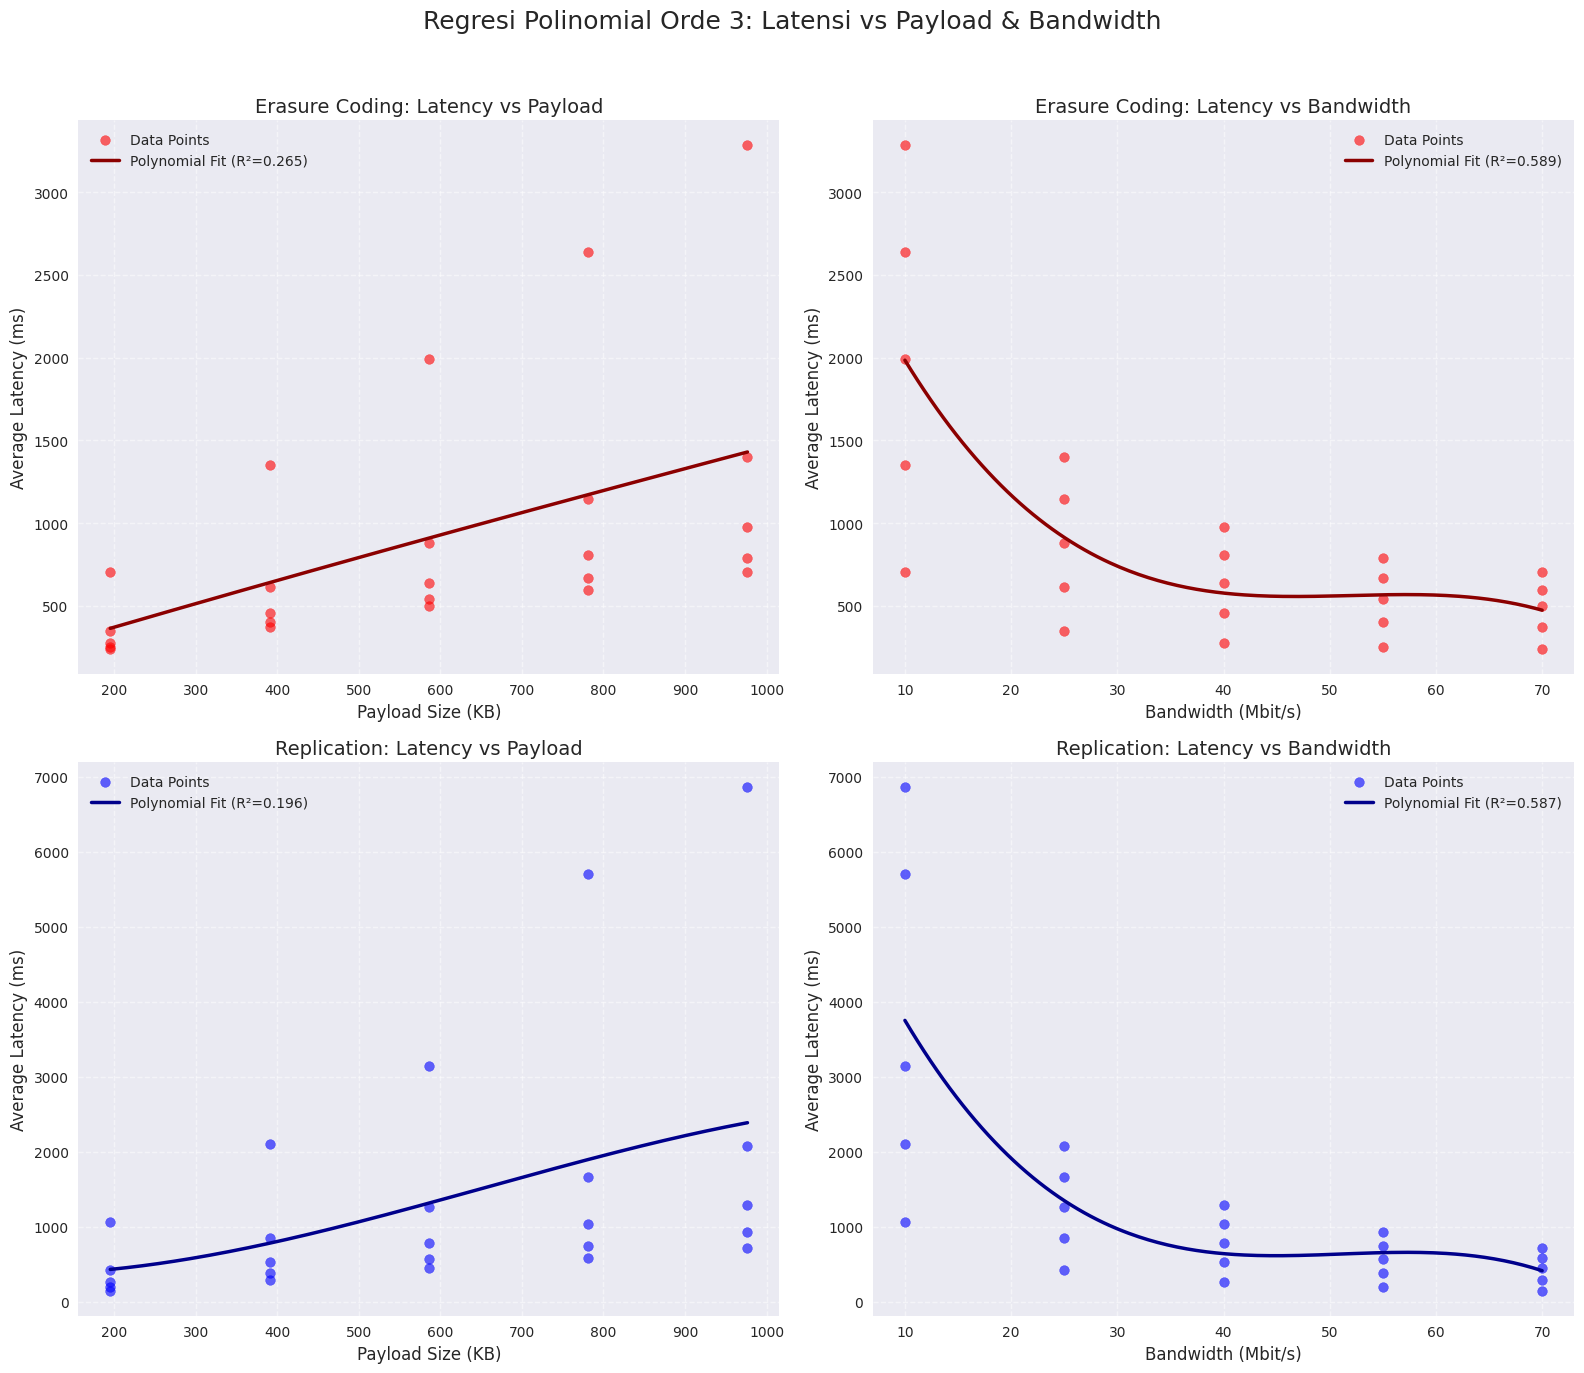

In [245]:
# Ekstrak data latensi untuk Erasure Coding dan Replication
ec_data = erasure_data.copy()
rep_data = replication_data.copy()

def perform_polynomial_regression(data, x_col, y_col, degree=3):
    """
    Melakukan analisis regresi polinomial dan mengembalikan model serta R-squared.
    """
    # Ambil data dan bentuk ulang untuk Scikit-learn
    X = data[x_col].values.reshape(-1, 1)
    y = data[y_col].values

    # Buat fitur polinomial
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X)

    # Latih model regresi linear pada fitur polinomial
    model = LinearRegression()
    model.fit(X_poly, y)

    # Prediksi untuk menghitung R-squared
    y_pred = model.predict(X_poly)
    r2 = r2_score(y, y_pred)

    return model, poly_features, r2

# --- Lakukan Regresi Polinomial untuk setiap kasus ---
# 1. EC: Payload
ec_model_payload, ec_poly_payload, ec_r2_payload = perform_polynomial_regression(ec_data, 'payload_kb', 'avg_latency_ms')

# 2. EC: Bandwidth
ec_model_bandwidth, ec_poly_bandwidth, ec_r2_bandwidth = perform_polynomial_regression(ec_data, 'bandwidth_mbit', 'avg_latency_ms')

# 3. Replication: Payload
rep_model_payload, rep_poly_payload, rep_r2_payload = perform_polynomial_regression(rep_data, 'payload_kb', 'avg_latency_ms')

# 4. Replication: Bandwidth
rep_model_bandwidth, rep_poly_bandwidth, rep_r2_bandwidth = perform_polynomial_regression(rep_data, 'bandwidth_mbit', 'avg_latency_ms')


# --- Visualisasi Scatter Plot dengan Kurva Polinomial ---
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Regresi Polinomial Orde 3: Latensi vs Payload & Bandwidth', fontsize=18)

# Plot 1: EC vs Payload
ax1 = axes[0, 0]
ax1.scatter(ec_data['payload_kb'], ec_data['avg_latency_ms'], color='red', alpha=0.6, label='Data Points')
# Buat garis kurva yang mulus
x_range = np.linspace(ec_data['payload_kb'].min(), ec_data['payload_kb'].max(), 200).reshape(-1, 1)
x_poly_range = ec_poly_payload.transform(x_range)
y_pred_range = ec_model_payload.predict(x_poly_range)
ax1.plot(x_range, y_pred_range, color='darkred', linewidth=2.5, label=f'Polynomial Fit (R²={ec_r2_payload:.3f})')
ax1.set_xlabel('Payload Size (KB)', fontsize=12)
ax1.set_ylabel('Average Latency (ms)', fontsize=12)
ax1.set_title('Erasure Coding: Latency vs Payload', fontsize=14)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.5)

# Plot 2: EC vs Bandwidth
ax2 = axes[0, 1]
ax2.scatter(ec_data['bandwidth_mbit'], ec_data['avg_latency_ms'], color='red', alpha=0.6, label='Data Points')
x_range = np.linspace(ec_data['bandwidth_mbit'].min(), ec_data['bandwidth_mbit'].max(), 200).reshape(-1, 1)
x_poly_range = ec_poly_bandwidth.transform(x_range)
y_pred_range = ec_model_bandwidth.predict(x_poly_range)
ax2.plot(x_range, y_pred_range, color='darkred', linewidth=2.5, label=f'Polynomial Fit (R²={ec_r2_bandwidth:.3f})')
ax2.set_xlabel('Bandwidth (Mbit/s)', fontsize=12)
ax2.set_ylabel('Average Latency (ms)', fontsize=12)
ax2.set_title('Erasure Coding: Latency vs Bandwidth', fontsize=14)
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.5)

# Plot 3: Replication vs Payload
ax3 = axes[1, 0]
ax3.scatter(rep_data['payload_kb'], rep_data['avg_latency_ms'], color='blue', alpha=0.6, label='Data Points')
x_range = np.linspace(rep_data['payload_kb'].min(), rep_data['payload_kb'].max(), 200).reshape(-1, 1)
x_poly_range = rep_poly_payload.transform(x_range)
y_pred_range = rep_model_payload.predict(x_poly_range)
ax3.plot(x_range, y_pred_range, color='darkblue', linewidth=2.5, label=f'Polynomial Fit (R²={rep_r2_payload:.3f})')
ax3.set_xlabel('Payload Size (KB)', fontsize=12)
ax3.set_ylabel('Average Latency (ms)', fontsize=12)
ax3.set_title('Replication: Latency vs Payload', fontsize=14)
ax3.legend()
ax3.grid(True, linestyle='--', alpha=0.5)

# Plot 4: Replication vs Bandwidth
ax4 = axes[1, 1]
ax4.scatter(rep_data['bandwidth_mbit'], rep_data['avg_latency_ms'], color='blue', alpha=0.6, label='Data Points')
x_range = np.linspace(rep_data['bandwidth_mbit'].min(), rep_data['bandwidth_mbit'].max(), 200).reshape(-1, 1)
x_poly_range = rep_poly_bandwidth.transform(x_range)
y_pred_range = rep_model_bandwidth.predict(x_poly_range)
ax4.plot(x_range, y_pred_range, color='darkblue', linewidth=2.5, label=f'Polynomial Fit (R²={rep_r2_bandwidth:.3f})')
ax4.set_xlabel('Bandwidth (Mbit/s)', fontsize=12)
ax4.set_ylabel('Average Latency (ms)', fontsize=12)
ax4.set_title('Replication: Latency vs Bandwidth', fontsize=14)
ax4.legend()
ax4.grid(True, linestyle='--', alpha=0.5)

# Menyesuaikan layout dan menampilkan plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


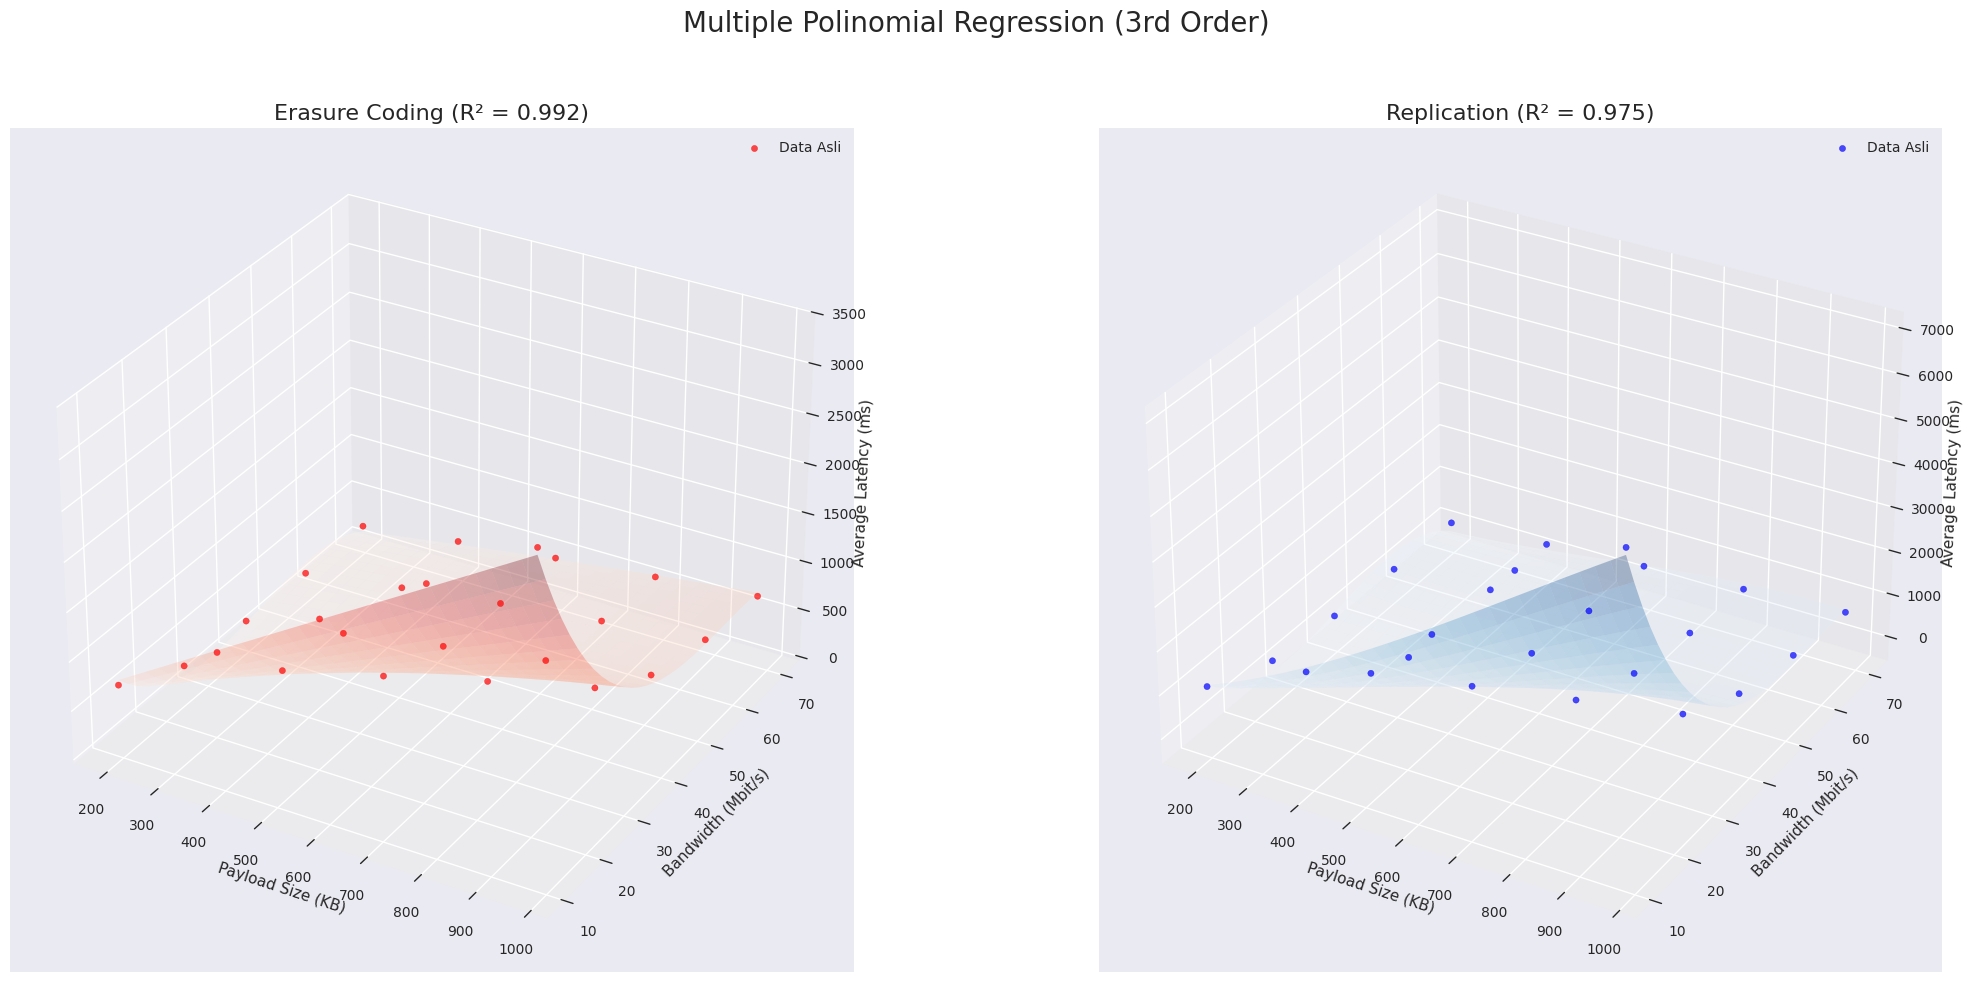

In [246]:
# Ekstrak data latensi untuk Erasure Coding dan Replication
ec_data = erasure_data.copy()
rep_data = replication_data.copy()


# --- 1. Regresi Gabungan untuk Erasure Coding ---

# Pilih fitur independen (X) dan target (y)
features = ['payload_kb', 'bandwidth_mbit']
target = 'avg_latency_ms'
X_ec = ec_data[features]
y_ec = ec_data[target]

# Buat fitur polinomial orde 3, termasuk interaksi antar fitur
poly_features_ec = PolynomialFeatures(degree=3, include_bias=False)
X_ec_poly = poly_features_ec.fit_transform(X_ec)

# Latih model regresi linear pada fitur polinomial
model_ec = LinearRegression()
model_ec.fit(X_ec_poly, y_ec)

# Prediksi dan hitung R-squared untuk model gabungan
y_ec_pred = model_ec.predict(X_ec_poly)
r2_ec_combined = r2_score(y_ec, y_ec_pred)


# --- 2. Regresi Gabungan untuk Replication ---

# Pilih fitur independen (X) dan target (y)
X_rep = rep_data[features]
y_rep = rep_data[target]

# Gunakan objek 'poly_features_ec' yang sama untuk transformasi
# agar konsisten, atau buat yang baru jika rentang datanya sangat berbeda
poly_features_rep = PolynomialFeatures(degree=3, include_bias=False)
X_rep_poly = poly_features_rep.fit_transform(X_rep)

# Latih model
model_rep = LinearRegression()
model_rep.fit(X_rep_poly, y_rep)

# Prediksi dan hitung R-squared
y_rep_pred = model_rep.predict(X_rep_poly)
r2_rep_combined = r2_score(y_rep, y_rep_pred)


# --- 3. Visualisasi Hasil sebagai Permukaan 3D ---

fig = plt.figure(figsize=(22, 10))
fig.suptitle('Multiple Polinomial Regression (3rd Order)', fontsize=20)

# --- Plot untuk Erasure Coding ---
ax1 = fig.add_subplot(121, projection='3d')

# Buat grid untuk permukaan plot
payload_range_ec = np.linspace(X_ec['payload_kb'].min(), X_ec['payload_kb'].max(), 30)
bandwidth_range_ec = np.linspace(X_ec['bandwidth_mbit'].min(), X_ec['bandwidth_mbit'].max(), 30)
payload_grid_ec, bandwidth_grid_ec = np.meshgrid(payload_range_ec, bandwidth_range_ec)

# Gabungkan grid untuk prediksi
grid_features_ec = np.c_[payload_grid_ec.ravel(), bandwidth_grid_ec.ravel()]
grid_poly_features_ec = poly_features_ec.transform(grid_features_ec)
latency_pred_ec = model_ec.predict(grid_poly_features_ec)
latency_pred_grid_ec = latency_pred_ec.reshape(payload_grid_ec.shape)

# Plot data asli (scatter) dan permukaan regresi
ax1.scatter(X_ec['payload_kb'], X_ec['bandwidth_mbit'], y_ec, color='red', alpha=0.7, label='Data Asli')
ax1.plot_surface(payload_grid_ec, bandwidth_grid_ec, latency_pred_grid_ec, alpha=0.3, cmap='Reds')

ax1.set_title(f'Erasure Coding (R² = {r2_ec_combined:.3f})', fontsize=16)
ax1.set_xlabel('Payload Size (KB)')
ax1.set_ylabel('Bandwidth (Mbit/s)')
ax1.set_zlabel('Average Latency (ms)')
ax1.legend()

# --- Plot untuk Replication ---
ax2 = fig.add_subplot(122, projection='3d')

# Buat grid untuk permukaan plot
payload_range_rep = np.linspace(X_rep['payload_kb'].min(), X_rep['payload_kb'].max(), 30)
bandwidth_range_rep = np.linspace(X_rep['bandwidth_mbit'].min(), X_rep['bandwidth_mbit'].max(), 30)
payload_grid_rep, bandwidth_grid_rep = np.meshgrid(payload_range_rep, bandwidth_range_rep)

# Gabungkan grid untuk prediksi
grid_features_rep = np.c_[payload_grid_rep.ravel(), bandwidth_grid_rep.ravel()]
grid_poly_features_rep = poly_features_rep.transform(grid_features_rep)
latency_pred_rep = model_rep.predict(grid_poly_features_rep)
latency_pred_grid_rep = latency_pred_rep.reshape(payload_grid_rep.shape)

# Plot data asli (scatter) dan permukaan regresi
ax2.scatter(X_rep['payload_kb'], X_rep['bandwidth_mbit'], y_rep, color='blue', alpha=0.7, label='Data Asli')
ax2.plot_surface(payload_grid_rep, bandwidth_grid_rep, latency_pred_grid_rep, alpha=0.3, cmap='Blues')

ax2.set_title(f'Replication (R² = {r2_rep_combined:.3f})', fontsize=16)
ax2.set_xlabel('Payload Size (KB)')
ax2.set_ylabel('Bandwidth (Mbit/s)')
ax2.set_zlabel('Average Latency (ms)')
ax2.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [9]:
# Extract coefficients and feature names from existing models
ec_coefficients = model_ec.coef_
ec_intercept = model_ec.intercept_
ec_feature_names = poly_features_ec.get_feature_names_out(['payload_kb', 'bandwidth_mbit'])

rep_coefficients = model_rep.coef_
rep_intercept = model_rep.intercept_
rep_feature_names = poly_features_rep.get_feature_names_out(['payload_kb', 'bandwidth_mbit'])

def display_step_by_step_formula(strategy_name, intercept, coefficients, feature_names):
    print(f"\n{strategy_name} Strategy:")
    print(f"Intercept (beta_0): {intercept:.6f}")
    
    print("\nCoefficient estimation process:")
    print("Latency = beta_0 + beta_1*P + beta_2*B + beta_3*P^2 + beta_4*P*B + beta_5*B^2 + beta_6*P^3 + beta_7*P^2*B + beta_8*P*B^2 + beta_9*B^3")
    
    print(f"\nSubstituting estimated coefficients:")
    print(f"Latency = {intercept:.6f}", end="")
    
    for i, (feature, coef) in enumerate(zip(feature_names, coefficients)):
        if abs(coef) > 1e-10:
            sign = "+" if coef >= 0 else "-"
            abs_coef = abs(coef)
            
            if feature == "payload_kb":
                print(f" {sign} {abs_coef:.6f}*P", end="")
            elif feature == "bandwidth_mbit":
                print(f" {sign} {abs_coef:.6f}*B", end="")
            elif feature == "payload_kb^2":
                print(f" {sign} {abs_coef:.9f}*P^2", end="")
            elif feature == "payload_kb bandwidth_mbit":
                print(f" {sign} {abs_coef:.6f}*P*B", end="")
            elif feature == "bandwidth_mbit^2":
                print(f" {sign} {abs_coef:.6f}*B^2", end="")
            elif feature == "payload_kb^3":
                print(f" {sign} {abs_coef:.9f}*P^3", end="")
            elif feature == "payload_kb^2 bandwidth_mbit":
                print(f" {sign} {abs_coef:.9f}*P^2*B", end="")
            elif feature == "payload_kb bandwidth_mbit^2":
                print(f" {sign} {abs_coef:.6f}*P*B^2", end="")
            elif feature == "bandwidth_mbit^3":
                print(f" {sign} {abs_coef:.6f}*B^3", end="")
    
    print()  # New line

display_step_by_step_formula("Erasure coding", ec_intercept, ec_coefficients, ec_feature_names)
display_step_by_step_formula("Replication", rep_intercept, rep_coefficients, rep_feature_names)



Erasure coding Strategy:
Intercept (beta_0): 710.876089

Coefficient estimation process:
Latency = beta_0 + beta_1*P + beta_2*B + beta_3*P^2 + beta_4*P*B + beta_5*B^2 + beta_6*P^3 + beta_7*P^2*B + beta_8*P*B^2 + beta_9*B^3

Substituting estimated coefficients:
Latency = 710.876089 + 4.440907*P - 79.778048*B - 0.000032723*P^2 - 0.138275*P*B + 2.409633*B^2 + 0.000000027*P^3 - 0.000002412*P^2*B + 0.001255*P*B^2 - 0.020174*B^3

Replication Strategy:
Intercept (beta_0): 1483.290998

Coefficient estimation process:
Latency = beta_0 + beta_1*P + beta_2*B + beta_3*P^2 + beta_4*P*B + beta_5*B^2 + beta_6*P^3 + beta_7*P^2*B + beta_8*P*B^2 + beta_9*B^3

Substituting estimated coefficients:
Latency = 1483.290998 + 5.216211*P - 155.004646*B + 0.007791596*P^2 - 0.337763*P*B + 5.269551*B^2 - 0.000003080*P^3 - 0.000044030*P^2*B + 0.003596*P*B^2 - 0.048131*B^3


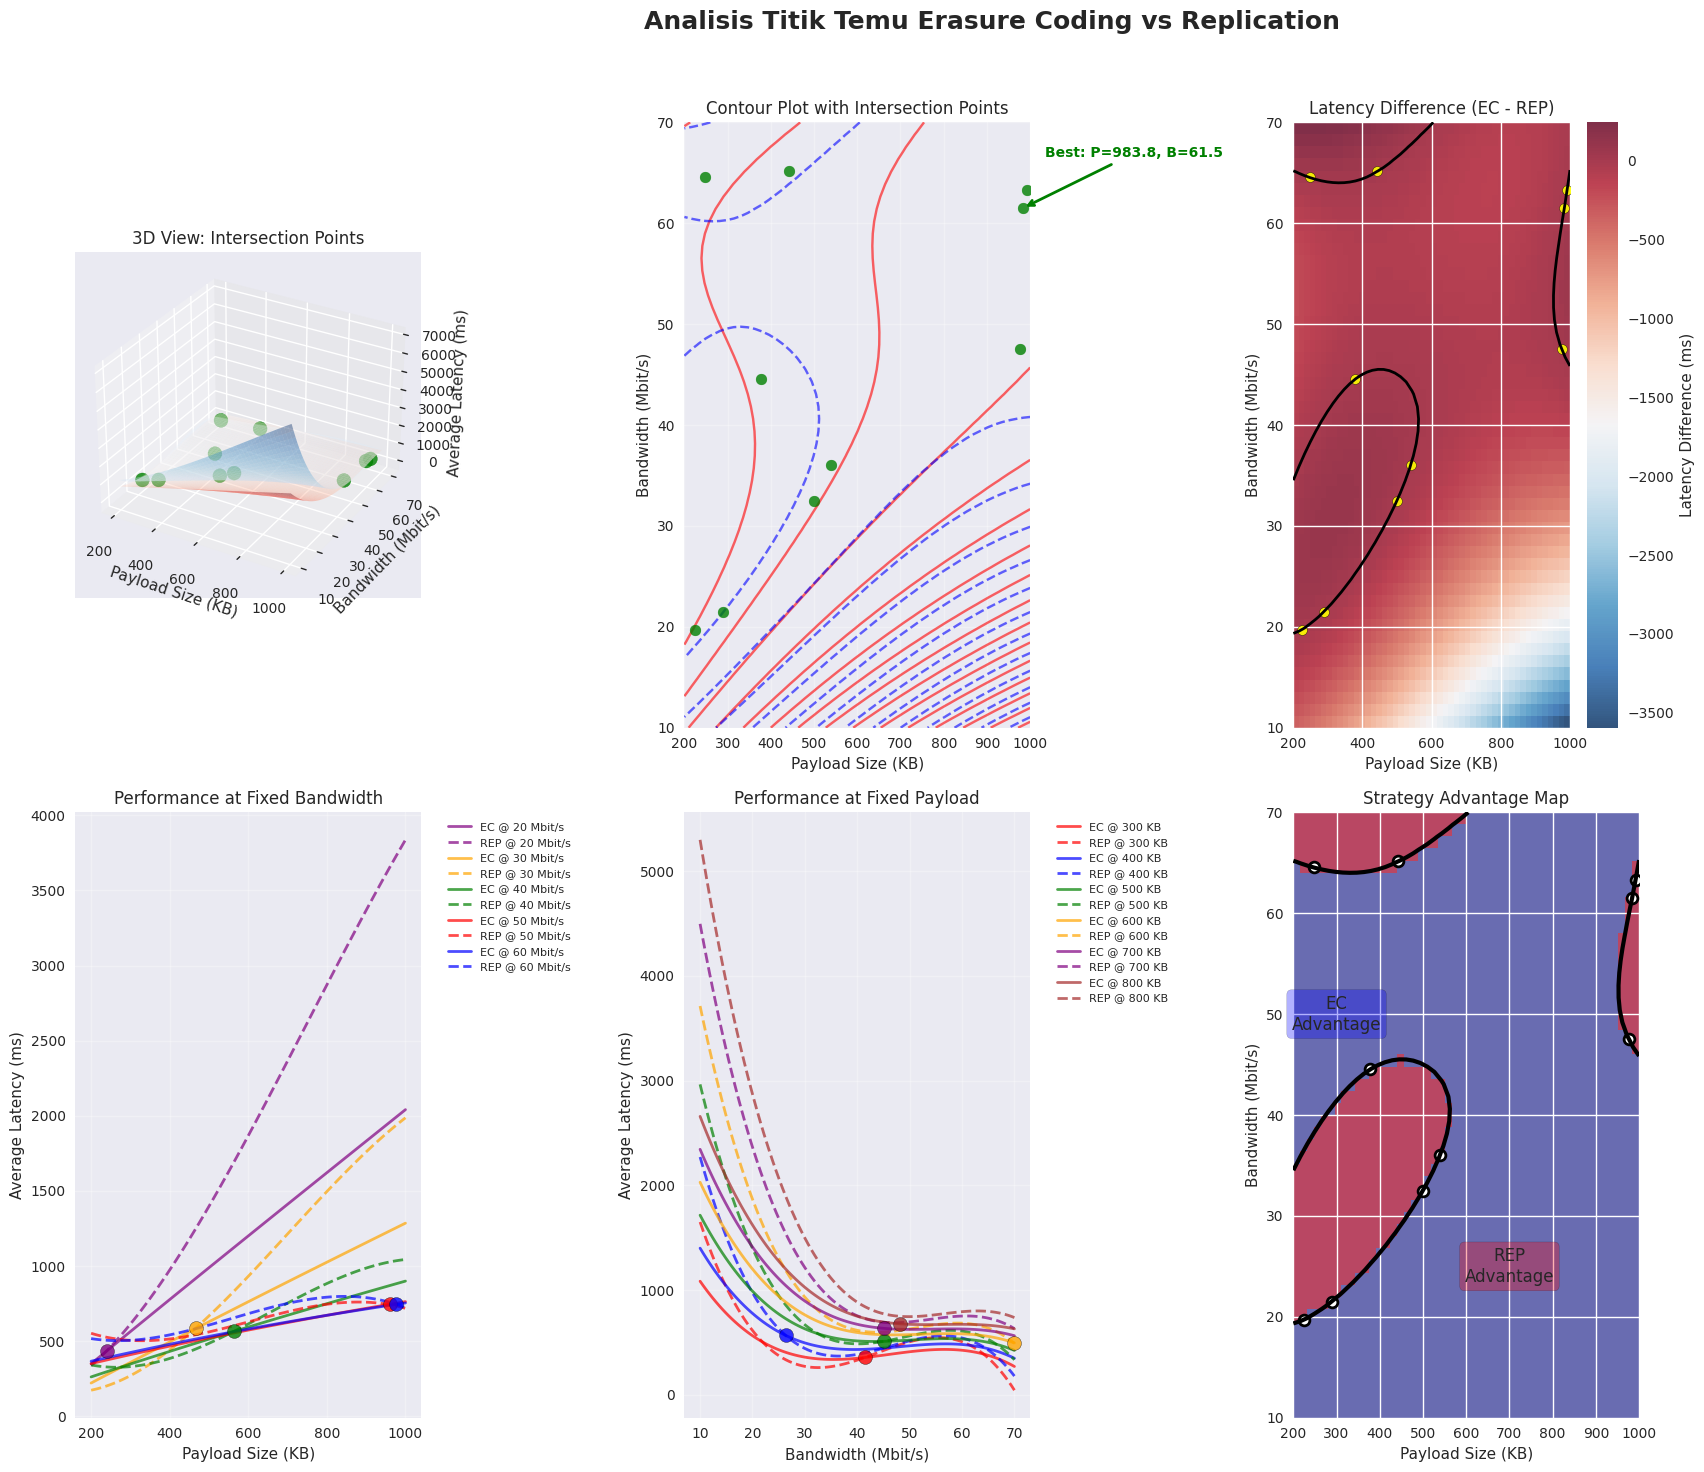

In [10]:
# Calculate intersection points and required variables
P_range = np.linspace(200, 1000, 100)
B_range = np.linspace(10, 70, 100)
P_grid, B_grid = np.meshgrid(P_range, B_range)

# Calculate latency for both strategies on the grid
grid_points = np.c_[P_grid.ravel(), B_grid.ravel()]
grid_poly_ec = poly_features_ec.transform(grid_points)
grid_poly_rep = poly_features_rep.transform(grid_points)

L_ec_grid = model_ec.predict(grid_poly_ec).reshape(P_grid.shape)
L_rep_grid = model_rep.predict(grid_poly_rep).reshape(P_grid.shape)

# Find intersection points (where difference is minimal)
L_diff = np.abs(L_ec_grid - L_rep_grid)
tolerance = 10.0  # ms
intersection_mask = L_diff < tolerance
intersection_indices = np.where(intersection_mask)

# Get intersection points
intersection_P = P_grid[intersection_indices]
intersection_B = B_grid[intersection_indices]
intersection_L_ec = L_ec_grid[intersection_indices]
intersection_L_rep = L_rep_grid[intersection_indices]
intersection_diff = L_diff[intersection_indices]

# Sort by difference
sort_indices = np.argsort(intersection_diff)

# Best intersection point
min_diff_indices = np.unravel_index(np.argmin(L_diff), L_diff.shape)
best_P = P_grid[min_diff_indices]
best_B = B_grid[min_diff_indices]

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 15))
fig.suptitle('Analisis Titik Temu Erasure Coding vs Replication', fontsize=18, fontweight='bold')

# 1. 3D Surface Plot with Intersection Points
ax1 = fig.add_subplot(231, projection='3d')

# Create finer grid for better visualization
P_fine = np.linspace(200, 1000, 50)
B_fine = np.linspace(10, 70, 50)
P_grid_fine, B_grid_fine = np.meshgrid(P_fine, B_fine)

# Calculate latency surfaces
grid_points_fine = np.c_[P_grid_fine.ravel(), B_grid_fine.ravel()]
grid_poly_ec_fine = poly_features_ec.transform(grid_points_fine)
grid_poly_rep_fine = poly_features_rep.transform(grid_points_fine)

L_ec_surface = model_ec.predict(grid_poly_ec_fine).reshape(P_grid_fine.shape)
L_rep_surface = model_rep.predict(grid_poly_rep_fine).reshape(P_grid_fine.shape)

# Plot surfaces
surf_ec = ax1.plot_surface(P_grid_fine, B_grid_fine, L_ec_surface, alpha=0.4, cmap='Reds', label='Erasure Coding')
surf_rep = ax1.plot_surface(P_grid_fine, B_grid_fine, L_rep_surface, alpha=0.4, cmap='Blues', label='Replication')

# Mark intersection points
intersection_P_top10 = intersection_P[sort_indices[:10]]
intersection_B_top10 = intersection_B[sort_indices[:10]]
intersection_L_avg_top10 = (intersection_L_ec[sort_indices[:10]] + intersection_L_rep[sort_indices[:10]]) / 2

ax1.scatter(intersection_P_top10, intersection_B_top10, intersection_L_avg_top10, 
           color='green', s=100, alpha=0.8, label='Intersection Points')

ax1.set_xlabel('Payload Size (KB)')
ax1.set_ylabel('Bandwidth (Mbit/s)')
ax1.set_zlabel('Average Latency (ms)')
ax1.set_title('3D View: Intersection Points')

# 2. Contour Plot with Intersection Line
ax2 = fig.add_subplot(232)

# Plot contour for both strategies
contour_ec = ax2.contour(P_grid_fine, B_grid_fine, L_ec_surface, levels=15, colors='red', alpha=0.6, linestyles='-')
contour_rep = ax2.contour(P_grid_fine, B_grid_fine, L_rep_surface, levels=15, colors='blue', alpha=0.6, linestyles='--')

# Plot intersection points
ax2.scatter(intersection_P_top10, intersection_B_top10, color='green', s=60, alpha=0.8, zorder=5)

# Add labels for best intersection point
ax2.annotate(f'Best: P={best_P:.1f}, B={best_B:.1f}', 
            xy=(best_P, best_B), xytext=(best_P+50, best_B+5),
            arrowprops=dict(arrowstyle='->', color='green', lw=2),
            fontsize=10, color='green', fontweight='bold')

ax2.set_xlabel('Payload Size (KB)')
ax2.set_ylabel('Bandwidth (Mbit/s)')
ax2.set_title('Contour Plot with Intersection Points')
ax2.grid(True, alpha=0.3)

# 3. Difference Heatmap
ax3 = fig.add_subplot(233)

L_diff_surface = L_ec_surface - L_rep_surface
im = ax3.imshow(L_diff_surface, extent=[200, 1000, 10, 70], aspect='auto', 
               cmap='RdBu_r', origin='lower', alpha=0.8)
ax3.contour(P_grid_fine, B_grid_fine, L_diff_surface, levels=[0], colors='black', linewidths=2)
ax3.scatter(intersection_P_top10, intersection_B_top10, color='yellow', s=50, alpha=0.9, edgecolor='black')

ax3.set_xlabel('Payload Size (KB)')
ax3.set_ylabel('Bandwidth (Mbit/s)')
ax3.set_title('Latency Difference (EC - REP)')
plt.colorbar(im, ax=ax3, label='Latency Difference (ms)')

# 4. Performance Comparison at Fixed Bandwidth
ax4 = fig.add_subplot(234)

fixed_B_values = [20, 30, 40, 50, 60]
colors_bw = ['purple', 'orange', 'green', 'red', 'blue']

P_range_fixed = np.linspace(200, 1000, 100)

for i, B_val in enumerate(fixed_B_values):
    # Calculate latencies for this bandwidth
    test_points = np.array([[p, B_val] for p in P_range_fixed])
    test_poly_ec = poly_features_ec.transform(test_points)
    test_poly_rep = poly_features_rep.transform(test_points)
    
    L_ec_fixed = model_ec.predict(test_poly_ec)
    L_rep_fixed = model_rep.predict(test_poly_rep)
    
    ax4.plot(P_range_fixed, L_ec_fixed, '-', color=colors_bw[i], alpha=0.7, linewidth=2, 
             label=f'EC @ {B_val} Mbit/s')
    ax4.plot(P_range_fixed, L_rep_fixed, '--', color=colors_bw[i], alpha=0.7, linewidth=2, 
             label=f'REP @ {B_val} Mbit/s')
    
    # Mark intersection
    diff_fixed = np.abs(L_ec_fixed - L_rep_fixed)
    min_idx = np.argmin(diff_fixed)
    ax4.scatter(P_range_fixed[min_idx], L_ec_fixed[min_idx], color=colors_bw[i], 
               s=100, alpha=0.8, edgecolor='black', zorder=5)

ax4.set_xlabel('Payload Size (KB)')
ax4.set_ylabel('Average Latency (ms)')
ax4.set_title('Performance at Fixed Bandwidth')
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax4.grid(True, alpha=0.3)

# 5. Performance Comparison at Fixed Payload
ax5 = fig.add_subplot(235)

fixed_P_values = [300, 400, 500, 600, 700, 800]
colors_payload = ['red', 'blue', 'green', 'orange', 'purple', 'brown']

B_range_fixed = np.linspace(10, 70, 100)

for i, P_val in enumerate(fixed_P_values):
    # Calculate latencies for this payload
    test_points = np.array([[P_val, b] for b in B_range_fixed])
    test_poly_ec = poly_features_ec.transform(test_points)
    test_poly_rep = poly_features_rep.transform(test_points)
    
    L_ec_fixed = model_ec.predict(test_poly_ec)
    L_rep_fixed = model_rep.predict(test_poly_rep)
    
    ax5.plot(B_range_fixed, L_ec_fixed, '-', color=colors_payload[i], alpha=0.7, linewidth=2, 
             label=f'EC @ {P_val} KB')
    ax5.plot(B_range_fixed, L_rep_fixed, '--', color=colors_payload[i], alpha=0.7, linewidth=2, 
             label=f'REP @ {P_val} KB')
    
    # Mark intersection
    diff_fixed = np.abs(L_ec_fixed - L_rep_fixed)
    min_idx = np.argmin(diff_fixed)
    ax5.scatter(B_range_fixed[min_idx], L_ec_fixed[min_idx], color=colors_payload[i], 
               s=100, alpha=0.8, edgecolor='black', zorder=5)

ax5.set_xlabel('Bandwidth (Mbit/s)')
ax5.set_ylabel('Average Latency (ms)')
ax5.set_title('Performance at Fixed Payload')
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax5.grid(True, alpha=0.3)

# 6. Strategy Advantage Map
ax6 = fig.add_subplot(236)

# Create advantage map
advantage_map = np.where(L_diff_surface < 0, 1, -1)  # 1 for EC advantage, -1 for REP advantage

im_adv = ax6.imshow(advantage_map, extent=[200, 1000, 10, 70], aspect='auto', 
                   cmap='RdYlBu', origin='lower', alpha=0.7)
ax6.contour(P_grid_fine, B_grid_fine, L_diff_surface, levels=[0], colors='black', linewidths=3)
ax6.scatter(intersection_P_top10, intersection_B_top10, color='white', s=60, alpha=1, 
           edgecolor='black', linewidth=2)

ax6.set_xlabel('Payload Size (KB)')
ax6.set_ylabel('Bandwidth (Mbit/s)')
ax6.set_title('Strategy Advantage Map')

# Add text annotations for regions
ax6.text(300, 50, 'EC\nAdvantage', fontsize=12, ha='center', va='center', 
         bbox=dict(boxstyle='round', facecolor='blue', alpha=0.3))
ax6.text(700, 25, 'REP\nAdvantage', fontsize=12, ha='center', va='center', 
         bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))

plt.tight_layout(rect=[0, 0, 0.85, 0.96])
plt.show()